### Notebook to Research diabetes onset 


#### Matched Controls Diabetes Onset Curve Construction Details

   1. <div style="background:Aliceblue"> <strong>Get all the canary patients who have their CC_DIABETES flag equals 0
    on their registration date.</strong>
   </div>
   
       - Pick a matching algorithm
       
   2. <div style="background:Aliceblue"><strong> Create the macthed population</strong> </div>
   
       - For each canary patient let their registration month be $i$
       - Find N(for example 50)  control patients to match this canary patient from the pmpm 
       patients on month i who have CC_DIABETES = 0 on month i. For example a matching specification could require the N patients should have the same age 
       and then be the nearest neighbors according to other features(log costs, cc codes etc).
       - Set the index date for these pmpm controls patients to be month $i$.
       - This forms a matched set of roughly 50 times the number of canary patients and each control has an index date.
   
   3. <div style="background:Aliceblue"><strong> Compute Onset of Diabetes for month $i$<strong></div> 
   
       - Get all the matched controls with index date prior to month $i$.
       - For Month i we define the total number of Diabetes Onsets(DO) as the number of subjects from <strong> 2 </strong> that had
        the flag $CC_{DIABETES} = 1$ at Month $(i)$ and $CC_{DIABETES} = 0$ at Month $(i-1)$ (Note these patients must be in pmpm on both months).
       - S is the total number of matched controls included in the pmpm both in month $i$ and month $i-1$
       - For Month i we define the diabetes onset rate(DOR) as: $DOR =  1000DO/S$

    <div style="background:Lightskyblue"> <strong>Suggestion:</strong> Remove from  $S$ the subjects that  have the flag $CC_{DIABETES} = 1$ at month $i-1$
    </div>

   

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython

In [2]:
%reload_ext Cython

In [3]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [31]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
import data_process
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )
from path import path_dict, col_seq_cc, col_seq_can, col_seq_cc_all, col_seq_can_all
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load Pmpm, Canary data

In [5]:
%%time
canary_p = '../../../data/CANARY'
pmpm_p = '../../../temp/PMPM.p'
preg_p = '../../../data/pregnancies'

preg = pq.read_table(preg_p).to_pandas()
canary = pq.read_table(canary_p).to_pandas()
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)
canary.drop_duplicates(subset = ['PERS_ID'], inplace = True)

CPU times: user 5.91 s, sys: 7.66 s, total: 13.6 s
Wall time: 26.8 s


In [6]:
pmpm.MEDICAID_LOB.unique()

array(['Medicare', 'Commercial', 'Other', 'ASO', 'Medicaid-HARP',
       'Medicaid-TANF', 'Medicaid-SSI', 'Medicaid-CHP', 'Medicaid-Other'],
      dtype=object)

### Include Line of Bussiness Feature 1 Not medicaid 0 medicaid

In [7]:
medicaid_mask = pmpm.MEDICAID_LOB.str.contains(r'.*Medicaid-.*')
pmpm['LOB'] = 1
pmpm.loc[medicaid_mask, 'LOB'] = 0
pmpm['MEDICAID_LOB'] = pmpm['LOB']
pmpm = pmpm.drop(['LOB'], axis=1)

In [8]:
pmpm.ALLOW_AMT = pmpm.ALLOW_AMT.apply(data_process.log_)
pmpm.ALLOW_IP = pmpm.ALLOW_IP.apply(data_process.log_)
pmpm.ALLOW_ER = pmpm.ALLOW_ER.apply(data_process.log_)

In [9]:
preg = preg.rename(mapper = {'person_id':'PERS_ID'}, axis = 1)
preg = pd.melt(preg, id_vars = ['PERS_ID'], value_vars=['stay_start_date', 'stay_end_date'], value_name='MYR')
preg.MYR = preg.MYR.apply(lambda x: x.year*100+x.month)
preg.drop(labels = 'variable', axis = 1, inplace = True)
preg['PREGNANCY'] = 1

In [10]:
%%time
pmpm = pmpm.merge(preg, how = 'left', on = ['PERS_ID', 'MYR'])
pmpm.PREGNANCY = pmpm.PREGNANCY.fillna(value = 0)
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)

CPU times: user 11.2 s, sys: 7.16 s, total: 18.4 s
Wall time: 18.4 s


In [11]:
# from utils import ip_er2

In [12]:
%%time
pmpm = pmpm.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
pmpm['IP_BIN'] = ((pmpm.ALLOW_IP>0) & (pmpm.PREGNANCY == 0)).astype(int)
pmpm['ER_BIN'] = ((pmpm.ALLOW_ER>0) & (pmpm.PREGNANCY == 0)).astype(int)
pmpm['ACUTE'] =  ((pmpm.IP_BIN>0) | (pmpm.ER_BIN > 0 )).astype(int)

CPU times: user 6.92 s, sys: 2.71 s, total: 9.63 s
Wall time: 9.63 s


In [13]:
%%time
pmpm[['IP_C', 'ER_C', 'ACUTE_C']] = pmpm.groupby('PERS_ID', sort = False)[['IP_BIN', 'ER_BIN', 'ACUTE']].cumsum().reset_index(drop = True)
pmpm[['IP_BIN6', 'ER_BIN6', 'ACUTE6']] = pmpm.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C', 'ACUTE_C']].diff(6).fillna(pmpm[['IP_C', 'ER_C','ACUTE_C']]).reset_index(drop = True)
pmpm[['IP_BIN2', 'ER_BIN2','ACUTE2']] = pmpm.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C','ACUTE_C']].diff(2).fillna(pmpm[['IP_C', 'ER_C','ACUTE_C']]).reset_index(drop = True)

CPU times: user 3min 48s, sys: 9.23 s, total: 3min 57s
Wall time: 3min 52s


#undersample
test = test.sample(random_state = 0, frac = 0.01).reset_index(drop = True)
test = test.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

%%time

test[['IP_C', 'ER_C']] = test.groupby('PERS_ID', sort = False)[['IP_BIN', 'ER_BIN']].cumsum().reset_index(drop = True)
test[['IP_BIN2', 'ER_BIN2']] = test.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C']].diff(6).fillna(test[['IP_C', 'ER_C']]).reset_index(drop = True)

In [14]:
pmpm.head()

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0      -3  201908        M              119        0.0             1       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
1      -3  201909        M              119        0.0             1       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
2      -3  201910        M              119        0.0             1       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
3      -3  201

### Process Canary data 
1. Drop register dates beyond pmpm max date
2. Transform register date to MYR
3. Keep only ids and MYR

### Get Controls and Treated
> ***a)Controls are all the patients that did not enrolled in canary program at any point  
b)Treated are the patients that enrolled at some point in the Canary Plan***

In [15]:
%%time
canary2 = process_canary(canary, pmpm.MYR.max())
treated, controls = get_tc(pmpm.copy(), canary2)

CPU times: user 9.59 s, sys: 5.78 s, total: 15.4 s
Wall time: 15.4 s


### filter by principal reason

In [16]:
controls.PERS_ID.unique().shape, treated.PERS_ID.unique().shape

Keep Canary Patients from their date of registration and onwards who did not have **CC_DIABETES** flag on, on their date of registration.

In [17]:
%%time
treated2 = in_canary(treated.copy(), canary2)
#treated2 = filter_first_month_diabetes(treated2.copy())
treated2.drop(columns = ['IN_CANARY'], inplace = True)

CPU times: user 5 s, sys: 128 ms, total: 5.13 s
Wall time: 5.13 s


In [18]:
treated2.PERS_ID.unique().shape

In [19]:
#cols = list(col for col in treated2.columns if col not in ['PERS_ID', 'MYR'])
#columns_to_match = cols
columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 'MEDICAID_LOB',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'IP_BIN2', 'ER_BIN2', 'ACUTE', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6']

In [20]:
onset = "CC_DIABETES"
cols_to_keep = ["PERS_ID", "MYR", onset]

In [21]:
import tensorflow as tf
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings('ignore')

model = models.load_model("../../../temp/TF_Latent_Model_m6_Canary_stacked", compile=False)

/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type

In [22]:
latent_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16']

In [23]:
%%time
#transform data of sick and healthy treated, and controls
tr2 = data_process.transform_features_with_NN(model, treated2[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)
cntrls = data_process.transform_features_with_NN(model, controls[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)

CPU times: user 1min 45s, sys: 24.2 s, total: 2min 10s
Wall time: 1min 15s


In [24]:
tr2

PERS_ID     MYR  CC_DIABETES        x1        x2         x3        x4        x5         x6         x7         x8        x9       x10       x11       x12       x13        x14       x15       x16
0      2602482  201908          0.0 -3.757803  0.201489  21.053392 -0.188058 -0.258382   9.807878 -17.703716 -26.212372  0.257452  0.516321 -0.241144 -0.351580 -0.038409 -11.247074  0.051218 -0.349894
1      2602482  201909          0.0 -3.803364  0.203395  21.287348 -0.189856 -0.260919   9.922577 -17.898434 -26.501665  0.258667  0.521520 -0.247130 -0.355684 -0.039263 -11.374065  0.050228 -0.353193
2      2602482  201910          0.0 -3.800138  0.203261  21.270792 -0.189726 -0.260741   9.914454 -17.884653 -26.481180  0.258581  0.521152 -0.246706 -0.355391 -0.039205 -11.365072  0.050301 -0.352960
3      2602482  201911          0.0 -3.857187  0.206081  21.569660 -0.191794 -0.263673  10.057518 -18.131847 -26.847900  0.259744  0.527494 -0.254843 -0.360452 -0.040480 -11.525246  0.049326 -0.356999
4      2602482  201912          0.0 -3.889507  0.207422  21.735523 -0.193094 -0.265457  10.138903 -18.269928 -27.053156  0.260602  0.531187 -0.259093 -0.363382 -0.041067 -11.615355  0.048590 -0.359333
...        ...     ...          ...       ...       ...        ...       ...       ...        ...        ...        ...       ...       ...       ...       ...       ...        ...       ...       ...
21863  5051413  202101          0.0  1.997140 -0.218349  -1.968134  0.022040 -0.882621  -2.291201   1.734830   1.940980  0.306455  0.161035  1.491977  0.033493  0.063035   1.963236  0.154905 -0.495870
21864  5051718  202101          0.0  1.782174 -0.186969  -1.721815  0.016847 -0.785707  -2.059640   1.485719   1.671553  0.293274  0.147716  1.347986  0.032109  0.057551   1.724971  0.153705 -0.443330
21865  5051718  202102          0.0  1.781550 -0.186821  -1.719808  0.016866 -0.785552  -2.058591   1.483955   1.669076  0.293282  0.147700  1.347547  0.032095  0.057519   1.723522  0.153736 -0.443263
21866  5051718  202103          0.0  1.779632 -0.186370  -1.713682  0.016926 -0.785074  -2.055385   1.478558   1.661515  0.293305  0.147651  1.346204  0.032054  0.057418   1.719092  0.153832 -0.443060
21867  5051718  202104          0.0  1.780975 -0.186684  -1.717961  0.016883 -0.785409  -2.057626   1.482331   1.666797  0.293290  0.147684  1.347143  0.032082  0.057488   1.722189  0.153765 -0.443202

[21868 rows x 19 columns]

In [32]:
%%time

#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
#hier_cols = ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6']
# hier_cols = ['CC_DX_CNT']
# hier_range = [1]
# exact_match_dict = {'ACUTE':None, 'ACUTE6':None, 'ACUTE2':None, 'LOB':None}
nnr_func_args = {'match_on':latent_cols, 'hier_cols':None,
                        'hier_range':None, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': False, 'exact_match_dict': None}
matched0, matched_data0 = matched_population(tr2.copy(), 
                                           cntrls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

"""
#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
propensity_func_args = {'match_on':columns_to_match, 'neighbors_per_treated': 5, 'onset': "CC_DIABETES", "onset_val" = 1}
matched0, matched_data0 = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)
"""


Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:315659 before they were:342223


1591it [26:30,  1.00it/s]

CPU times: user 41min 51s, sys: 25min 14s, total: 1h 7min 5s
Wall time: 26min 34s


'\n#columns_to_match = columns_to_match + [\'IP_BIN2\', \'ER_BIN2\']\npropensity_func_args = {\'match_on\':columns_to_match, \'neighbors_per_treated\': 5, \'onset\': "CC_DIABETES", "onset_val" = 1}\nmatched0, matched_data0 = matched_population(treated2.copy(), \n                                           controls.copy(),\n                                           propensity_func, \n                                           propensity_func_args)\n'

####  In addition to the previously created matched groups create a random group

In [33]:
Path('./tempHybridSelectionMoreData').mkdir(exist_ok = True)
p = './tempHybridSelectionMoreData/'

In [34]:
random_matching_func_args = {'neighbors_per_treated': 5}
random_controls = matched_population(tr2.copy(), 
                                    cntrls.copy(),
                                    random_matching_func, 
                                    random_matching_func_args)

Mathcing Function: random_matching_func


In [35]:
matched_data0.to_pickle(p+'match0_l.p')
random_controls.to_pickle(p+'random_l.p')
tr2.to_pickle(p+'treated0_l.p')

In [36]:
matched_data0_o = controls[controls.set_index(["PERS_ID", "MYR"]).index.isin(matched_data0.set_index(["PERS_ID", "MYR"]).index)].sort_values(by=["PERS_ID", "MYR"])
random_controls_o = controls[controls.set_index(["PERS_ID", "MYR"]).index.isin(random_controls.set_index(["PERS_ID", "MYR"]).index)].sort_values(by=["PERS_ID", "MYR"])

In [37]:
matched_data0_o.to_pickle(p+'match0_o.p')
random_controls_o.to_pickle(p+'random_o.p')
treated2.to_pickle(p+'treated0_o.p')

In [38]:
import os
files_list = os.listdir(p)

#save in S3
import boto3
s3 = boto3.client('s3')
bucket = 'cdphp-s3-us-e-p-pond'
for file in files_list:
    s3.upload_file( p +file,
                    bucket, 
                    'rpi/nneehal/DATA/m6_CAN_Stacked_202108/'+file,
                    ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})

In [39]:
files_list

['match0_l.p',
 'random_l.p',
 'treated0_l.p',
 'match0_o.p',
 'random_o.p',
 'treated0_o.p']

#### Calculate the Diabetes onset for each of the created groups
1. Group 0: Group of treated patients cluster 0
2. Group 1: Group of treated patients Cluster 1
3. Group 2: Group of matched control patients to Group 0
4. Group 3: Group of matched control patients to Group 1
5. Group 4: Random Group

In [40]:
from utils import statistics_first_month

In [41]:
pmpm2 = pmpm
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [42]:
%%time
tr_desc0, Ntr, treated_first_month = statistics_first_month(treated2, columns_to_match, return_array = True)
tr_desc0 = tr_desc0.T



con_desc0, Ncon, controls_first_month = statistics_first_month(matched_data0_o, columns_to_match, return_array = True)
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0 = con_desc0.T

pmpm_desc, Npmpm = statistics_first_month(pmpm2, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_desc = pmpm_desc.T

random_desc, Nra = statistics_first_month(random_controls_o, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_desc = random_desc.T

CPU times: user 2min 27s, sys: 6.66 s, total: 2min 34s
Wall time: 2min 34s


In [43]:
import scipy.stats as sts

In [44]:
args = {'mean1':tr_desc0['mean'], 'std1':tr_desc0['std'], 'mean2':con_desc0['mean'], 'std2':con_desc0['std'], 'nobs1': np.full(len(tr_desc0), Ntr) , 'nobs2': np.full(len(tr_desc0), Ncon)}
stats, pval = sts.ttest_ind_from_stats(**args)
stats = pd.DataFrame(stats, columns = ['t-stat'])
stats['pval'] = pval

In [45]:
alli = pd.concat((tr_desc0['mean'], con_desc0['mean'], stats, pmpm_desc['mean'], random_desc['mean']), axis = 1, keys = ['Treated', 'Matched Controls', 'T-Test', 'Genaral Population', 'Random'] )

In [46]:
alli

Treated Matched Controls     T-Test               Genaral Population     Random
                      mean             mean     t-stat          pval               mean       mean
AGE_AT_MIDMONTH  50.202388        50.243928  -0.117507  9.064605e-01          44.643167  47.578065
ALLOW_AMT         4.239488         4.230511   0.121173  9.035565e-01           4.726962   3.712194
MBR_GNDR          0.205531         0.382084 -13.550809  1.945806e-41           0.440779   0.429230
CC_TOBACCO        0.062225         0.121050  -6.814801  1.002913e-11           0.076138   0.096365
CC_PRESSURE       0.001257         0.002873  -1.152677  2.490729e-01           0.007643   0.006527
CC_OBESITY        0.456945         0.296814  12.518533  1.149481e-35           0.113117   0.228052
MEDICAID_LOB      0.952231         0.829721  12.585078  5.030279e-36           0.759449   0.784873
CC_HYPERTENSION   0.324324         0.275790   3.908643  9.347851e-05           0.216240   0.261326
CC_HYPOTHYROID    0.094280         0.075868   2.477477  1.324922e-02           0.048990   0.066675
CC_DX_CNT         2.703331         2.533429   2.946067  3.226458e-03           1.882424   2.388021
IP_BIN2           0.010057         0.008749   0.497177  6.190762e-01           0.020502   0.014589
ER_BIN2           0.029541         0.034343  -0.931703  3.515141e-01           0.046638   0.042616
ACUTE             0.014456         0.020893  -1.677646  9.344996e-02           0.062499   0.026875
ACUTE2            0.037712         0.041917  -0.728978  4.660335e-01           0.062499   0.053878
ACUTE6            0.110622         0.133194  -1.915941  5.540339e-02           0.062499   0.160353
IP_BIN6           0.027027         0.033951  -1.219062  2.228519e-01           0.020502   0.044663
ER_BIN6           0.087995         0.105119  -1.652470  9.847272e-02           0.046638   0.124904

## Statistics on matching date

#### Univariate Means of the Groups under Study of interesting features (Statistics for whole populations)
>The "Sick groups" have:  
a) Older age  
b) More Expenditures  
c) Smoke More  
d) Have More People with Hypertension


In [47]:
tr_desc0A = treated2[columns_to_match].describe().loc[['mean', 'std']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc0A = tr_desc0A.T


con_desc0A = matched_data0_o[columns_to_match].describe().loc[['mean', 'std']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0A = con_desc0A.T


pmpm_descA = pmpm2[columns_to_match].describe().loc[['mean','std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_descA = pmpm_descA.T

random_descA = random_controls_o[columns_to_match].describe().loc[['mean','std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_descA = random_descA.T



In [48]:
args = {'mean1':tr_desc0A['mean'], 'std1':tr_desc0A['std'],
        'mean2':con_desc0A['mean'], 'std2':con_desc0A['std'],
        'nobs1': np.full(len(tr_desc0), len(treated2)) , 'nobs2': np.full(len(tr_desc0), len(matched_data0))}
stats, pval = sts.ttest_ind_from_stats(**args)
stats = pd.DataFrame(stats, columns = ['t-stat'])
stats['pval'] = pval

In [49]:
alli2 = pd.concat((tr_desc0A, con_desc0A, stats['pval'], pmpm_descA['mean'], random_descA['mean']), axis = 1, keys = ['Treated',
                                                                                 'Matched Controls','T-Test',
                                                                                'Genaral Population', 
                                                                                 'Random'] )
alli2

Treated            Matched Controls                    T-Test Genaral Population     Random
                      mean        std             mean        std           pval               mean       mean
AGE_AT_MIDMONTH  50.609018  12.498347        50.900138  12.546161   1.906312e-03          50.562788  49.841932
ALLOW_AMT         4.159157   2.781989         4.009277   2.805090   8.446749e-13           4.036216   3.776045
MBR_GNDR          0.186437   0.389468         0.380269   0.485455   0.000000e+00           0.432518   0.421937
CC_TOBACCO        0.064386   0.245445         0.127478   0.333509  2.094658e-153           0.101788   0.105292
CC_PRESSURE       0.002195   0.046800         0.005158   0.071631   5.115685e-09           0.013009   0.008076
CC_OBESITY        0.506722   0.499966         0.334270   0.471737   0.000000e+00           0.256968   0.278993
MEDICAID_LOB      0.953677   0.210189         0.825573   0.379478   0.000000e+00           0.804859   0.803918
CC_HYPERTENSION   0.322480   0.467436         0.299750   0.458151   3.893228e-11           0.334809   0.301956
CC_HYPOTHYROID    0.094430   0.292433         0.081581   0.273727   5.784795e-10           0.079339   0.074908
CC_DX_CNT         2.878270   2.239593         2.791309   2.207026   1.492578e-07           2.987871   2.729799
IP_BIN2           0.007682   0.087836         0.011714   0.114584   9.986962e-07           0.020215   0.015592
ER_BIN2           0.025334   0.170001         0.031711   0.183877   2.606927e-06           0.044067   0.035658
ACUTE             0.015228   0.122460         0.020385   0.141314   5.914197e-07           0.030817   0.023481
ACUTE2            0.031827   0.188605         0.041669   0.212850   2.859205e-10           0.060657   0.048271
ACUTE6            0.101061   0.401935         0.128918   0.425840   1.017254e-18           0.168279   0.149566
IP_BIN6           0.024694   0.165185         0.036317   0.227437   8.839229e-13           0.055082   0.046672
ER_BIN6           0.080209   0.367004         0.098157   0.361782   3.722715e-11           0.123105   0.111790

In [50]:
random_controls.head()

PERS_ID     MYR  CC_DIABETES        x1        x2         x3        x4        x5        x6         x7         x8        x9       x10       x11       x12       x13       x14       x15       x16
0  2654895  201710          0.0 -2.836715  0.158721  16.264881 -0.153311 -0.209677  7.494320 -13.733488 -20.318296  0.236507  0.412856 -0.113677 -0.269217 -0.019246 -8.667859  0.068910 -0.284181
1  2654895  201711          0.0 -2.836715  0.158721  16.264881 -0.153311 -0.209677  7.494320 -13.733488 -20.318296  0.236507  0.412856 -0.113677 -0.269217 -0.019246 -8.667859  0.068910 -0.284181
2  2654895  201712          0.0 -2.836715  0.158721  16.264881 -0.153311 -0.209677  7.494320 -13.733488 -20.318296  0.236507  0.412856 -0.113677 -0.269217 -0.019246 -8.667859  0.068910 -0.284181
3  2654895  201801          0.0 -2.836715  0.158721  16.264881 -0.153311 -0.209677  7.494320 -13.733488 -20.318296  0.236507  0.412856 -0.113677 -0.269217 -0.019246 -8.667859  0.068910 -0.284181
4  2654895  201802          0.0 -2.868641  0.160046  16.428728 -0.154595 -0.211438  7.574714 -13.869887 -20.521046  0.237355  0.416504 -0.117875 -0.272111 -0.019826 -8.756869  0.068183 -0.286486

In [51]:
columns_to_match = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16']

tr_desc0 = tr2[columns_to_match].describe().loc[['mean','std']].T
con_desc0 = matched_data0[columns_to_match].describe().loc[['mean','std']].T
random_desc = random_controls[columns_to_match].describe().loc[['mean','std']].T

alli_latent = pd.concat((tr_desc0, con_desc0, random_desc), axis = 1, keys = ['Treated', 'Matched Controls', 'Random'] )

In [52]:
alli_latent

Treated           Matched Controls              Random          
         mean       std             mean       std      mean       std
x1  -0.760332  1.485548        -0.794434  1.482434 -0.707071  2.018662
x2   0.035988  0.117046         0.038317  0.116387  0.014949  0.157614
x3   6.609539  5.837430         6.753404  5.844805  7.189873  7.939404
x4  -0.074949  0.054436        -0.076223  0.054348 -0.074215  0.073594
x5  -0.261644  0.262386        -0.258824  0.259766 -0.371621  0.337596
x6   2.645749  3.074550         2.720260  3.075126  2.813049  4.179759
x7  -5.675147  4.925945        -5.796088  4.930894 -6.110975  6.702000
x8  -8.441390  7.147717        -8.617878  7.157538 -9.187026  9.714747
x9   0.223087  0.037933         0.222932  0.037573  0.242939  0.047378
x10  0.228224  0.098155         0.230641  0.098634  0.258260  0.131248
x11  0.334408  0.514028         0.325066  0.510371  0.456472  0.685383
x12 -0.104192  0.098141        -0.106626  0.098303 -0.115778  0.133158
x13  0.019801  0.025074         0.019203  0.025077  0.018990  0.034655
x14 -3.332727  3.348217        -3.414136  3.349609 -3.545343  4.556763
x15  0.109054  0.026961         0.108413  0.026930  0.108775  0.036314
x16 -0.232060  0.119548        -0.231740  0.118466 -0.296138  0.149773

# Metric

In [59]:
controls

PERS_ID     MYR  MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  \
0             -3  201908         1              119        0.0             1       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
1             -3  201909         1              119        0.0             1       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
2             -3  201910         1              119        0.0             1       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
3             -3  201911         1   

In [60]:
matched_data0_o

PERS_ID     MYR  MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  \
250342   2600040  202102         1               83   3.951244             1       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          4                    0.0          0.0              0.0          1.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              1.0             0.0           0.0          1.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
250343   2600040  202103         1               83   5.616771             1       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          2                    0.0          0.0              0.0          1.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          1.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
250344   2600040  202104         1               84   0.000000             1       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          2                    0.0          0.0              0.0          1.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          1.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
251282   2600134  202001         0   

In [61]:
treated2

PERS_ID     MYR  MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  \
0      2602482  201908         0               81   0.000000             1       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                1          1                    0.0          0.0              0.0          0.0                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
1      2602482  201909         0               81   7.229114             1       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                1          2                    0.0          0.0              0.0          0.0                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              1.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
2      2602482  201910         0               81   6.605298             1       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                1          2                    0.0          0.0              0.0          0.0                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              1.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
3      2602482  201911         0           

In [116]:
disease_cols = [cols for cols in treated2.columns if "CC" in cols and cols!='CC_DX_CNT']
other_binary_cols = ['MBR_GNDR', 'MEDICAID_LOB', 'PREGNANCY', 'IP_BIN', 'ER_BIN', 'ACUTE']
binary_cols = other_binary_cols + disease_cols 
restricted_cols = ['PERS_ID', 'MYR']
continuous_cols = [cols for cols in treated2.columns if cols not in binary_cols + restricted_cols]

In [118]:
def calculate_continuous_d(t, c):
    Xt = np.mean(t)
    Xc = np.mean(c)
    St = np.std(t)
    Sc = np.std(c)
    d = np.abs((Xt-Xc)/(np.sqrt((St**2 + Sc**2)/2)))
    return d

In [119]:
def calculate_binary_d(t, c):
    Pt = np.mean(t)
    Pc = np.mean(c)
    d = np.abs((Pt-Pc)/(np.sqrt((Pt*(1-Pt)+Pc*(1-Pc))/2)))
    return d

In [120]:
d_metric_before = pd.DataFrame()
for col in treated2.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated2[[col]].values, controls[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated2[[col]].values, controls[[col]].values)
        d_metric_before.loc[0,col] = d

In [121]:
d_metric_before

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  MEDICAID_LOB  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR   CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0  0.555757         0.002733   0.043585      0.471735  0.066435  0.083354  0.018151       0.11775           0.194178  0.045403   0.042007             0.120949      0.032886   0.090428       0.136668   0.093798    0.025094  0.14636          0.075276      0.03999           0.017091           0.256413              0.052188  0.133836             0.02511       0.068564                 0.060401           0.036649     0.389055         0.110183   0.042956               0.015324     0.062221         0.013721     0.074928           0.040004          0.124449        0.013825              0.007703                0.025773               0.02498                0.074542                    0.052027        0.005423        0.003745          0.082729         0.057982           0.089072         0.026472        0.053949      0.064822     0.159508        0.047035      0.000869   0.04177        0.046135     0.187421            0.060944               0.062881               0.029188    0.534943   

   CC_OSTEOPOROSIS  CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  PREGNANCY    IP_BIN   ER_BIN     ACUTE     IP_C      ER_C   ACUTE_C   IP_BIN6   ER_BIN6    ACUTE6   IP_BIN2  ER_BIN2    ACUTE2  
0         0.076485       0.183094        0.013207     0.125334            0.097772  0.030216          0.077758                0.113311        0.049555         0.011915   0.055976    0.136736            0.020372          0.043959   0.038401  0.079577  0.07946  0.104553  0.02994  0.061297  0.046237  0.132301  0.108772  0.147671  0.102416  0.09602  0.127896

In [122]:
d_metric_after = pd.DataFrame()
for col in treated2.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated2[[col]].values, matched_data0_o[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated2[[col]].values, matched_data0_o[[col]].values)
        d_metric_after.loc[0,col] = d

In [123]:
d_metric_after

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0  0.440446         0.023249   0.053652      0.417628  0.019216  0.032558  0.03235      0.051166            0.10502  0.031339   0.004042             0.016316      0.009291   0.066951       0.007508   0.069562    0.046331  0.083028          0.062349      0.02692           0.012581           0.002723              0.021127  0.060187            0.013327       0.000764                 0.034375           0.014947     0.148678         0.044195   0.039113                0.03496     0.056554         0.063362     0.011819           0.011093          0.010698             NaN              0.004127                0.050536               0.04337                0.093445                    0.059541          0.0226             NaN          0.104045         0.037826           0.027205         0.049114        0.045367      0.042714     0.081503        0.022027      0.025911  0.008643        0.007136     0.100744            0.027992               0.036272                    NaN    0.354805   

   CC_OSTEOPOROSIS  CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  PREGNANCY   IP_BIN    ER_BIN     ACUTE      IP_C      ER_C   ACUTE_C  IP_BIN6   ER_BIN6    ACUTE6   IP_BIN2   ER_BIN2    ACUTE2  
0         0.050081       0.021733        0.019582     0.048966            0.049701  0.033436          0.095443                0.113912        0.047393         0.000464    0.01551    0.215474            0.025932          0.027669   0.025421  0.02983  0.029425  0.039005  0.045657  0.045088  0.055002  0.05848  0.049254  0.067279  0.039493  0.036015  0.048941

In [127]:
ratio = d_metric_after/d_metric_before
ratio

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  MEDICAID_LOB  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0  0.792515         8.507593   1.230996      0.885302  0.289245  0.390593  1.782216       0.43453           0.540842  0.690233    0.09621             0.134898      0.282523   0.740371       0.054934   0.741611    1.846275  0.567285          0.828265     0.673155           0.736099           0.010619              0.404823  0.449708            0.530755       0.011147                 0.569107           0.407837     0.382152         0.401111   0.910524               2.281373     0.908914            4.618     0.157735           0.277309          0.085965             NaN              0.535766                 1.96083              1.736179                1.253589                    1.144436        4.167849             NaN          1.257661         0.652377           0.305424         1.855315        0.840919      0.658936     0.510963        0.468306     29.805224  0.206912        0.154668     0.537529            0.459301               0.576838                    NaN    0.663257   

   CC_OSTEOPOROSIS  CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  PREGNANCY    IP_BIN    ER_BIN     ACUTE      IP_C     ER_C   ACUTE_C   IP_BIN6   ER_BIN6    ACUTE6   IP_BIN2   ER_BIN2   ACUTE2  
0         0.654779       0.118696        1.482719     0.390683            0.508337  1.106573          1.227432                1.005309        0.956383         0.038958   0.277086    1.575838             1.27288          0.629432   0.661985  0.374863  0.370307  0.373062  1.524966  0.73556  1.189573  0.442023  0.452818  0.455597  0.385613  0.375084  0.38266

In [134]:
ratio.T[ratio.T[0]>=1.0]

0
AGE_AT_MIDMONTH              8.507593
ALLOW_AMT                    1.230996
CC_ADHD                      1.782216
CC_BIPOLAR                   1.846275
CC_ENDOMETRIAL_CANCER        2.281373
CC_FIBROMYALGIA              4.618000
CC_HEPATITIS_B_CHRONIC       1.960830
CC_HEPATITIS_C_ACUTE         1.736179
CC_HEPATITIS_C_CHRONIC       1.253589
CC_HEPATITIS_C_UNSPECIFIED   1.144436
CC_HEPATITIS_D               4.167849
CC_HEPATITIS_GEN             1.257661
CC_HYPERTENSION              1.855315
CC_LEUKEMIAS                29.805224
CC_PERSONALITY               1.482719
CC_PTSD                      1.106573
CC_SCHIZOPHRENIA             1.227432
CC_SCHIZOPHRENIA_OTHER       1.005309
CC_TOBACCO                   1.575838
CC_TRAUMATIC_BRAIN           1.272880
IP_C                         1.524966
ACUTE_C                      1.189573

In [149]:
ratio.T[ratio.T[0]>=1.0].size

22

In [133]:
ratio.T.size

88

### Only ratio of MAD

In [140]:
before = np.abs(treated2[binary_cols+continuous_cols].mean() - controls[binary_cols+continuous_cols].mean())
after  = np.abs(treated2[binary_cols+continuous_cols].mean() - matched_data0_o[binary_cols+continuous_cols].mean())
MAD_ratio = after/before

In [147]:
MAD_ratio[MAD_ratio>1.0]

CC_ADHD                        1.751999
CC_BIPOLAR                     1.898388
CC_ENDOMETRIAL_CANCER          2.072408
CC_FIBROMYALGIA                4.835715
CC_HEPATITIS_B_CHRONIC         2.952935
CC_HEPATITIS_C_ACUTE           3.012425
CC_HEPATITIS_C_CHRONIC         1.459872
CC_HEPATITIS_C_UNSPECIFIED     1.218749
CC_HEPATITIS_D                17.366782
CC_HEPATITIS_GEN               1.413779
CC_HYPERTENSION                1.828106
CC_LEUKEMIAS                  27.715245
CC_PERSONALITY                 1.559768
CC_PTSD                        1.207955
CC_SCHIZOPHRENIA               1.337280
CC_SCHIZOPHRENIA_OTHER         1.007691
CC_TOBACCO                     1.674314
CC_TRAUMATIC_BRAIN             1.317842
AGE_AT_MIDMONTH                6.498409
ALLOW_AMT                      1.208324
IP_C                           1.620387
ACUTE_C                        1.252645
dtype: float64

In [148]:
MAD_ratio[MAD_ratio>1.0].size

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Matrices and Figures for the paper

In [53]:
#mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco use', 'Pressure', 'Obesity', 
                                     #'Hypertension', 'Hypothyroid', 'Disease Count', 'Inpatient Visits', 'Emergency Vistits', 'Line of Bussiness']))
mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [54]:
p = Path('./res/figs')
p.mkdir(parents = True, exist_ok = True)

In [55]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

1. treated_first_month
2. controls_first_month

In [56]:
from diabetes_onset_plotter import plot_hist


KeyError: 'x1'

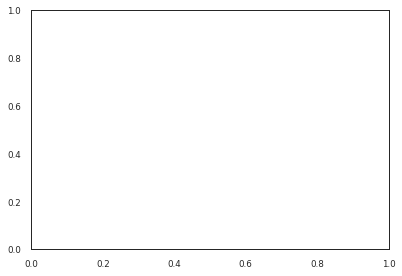

In [57]:
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = 'res/figs/',
                dist_plot_args = dist_plot_args)

Save Three arrays
1. All Statistics
2. Only Means
3. Difference T-Statistic Pvalues

In [ ]:
from diabetes_onset_plotter import save_arrays
p2 = Path('./res/tabs')
p2.mkdir(parents = True, exist_ok = True)
paths = ['./res/tabs/all_stats.csv', './res/tabs/only_means.csv', './res/tabs/only_stats.csv']
(all_paper, only_means, only_stats) = save_arrays(alli, paths, mapping)

In [ ]:
all_paper


In [ ]:
only_means

In [ ]:
only_stats

In [ ]:
pmpm.MYR.max()